In [1]:
from abc import ABC, abstractmethod
from copy import deepcopy
import os
from typing import (Any, Callable, Dict, List, Optional, Tuple, Type,
                    Union, cast)
os.environ["CUDA_VISIBLE_DEVICES"]="3,2,1,0"
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split

from graphnet.constants import EXAMPLE_DATA_DIR, EXAMPLE_OUTPUT_DIR, GRAPHNET_ROOT_DIR
from graphnet.data.constants import FEATURES, TRUTH
from graphnet.data.dataset import Dataset, ParquetDataset, SQLiteDataset
from graphnet.data.dataset.dataset import ColumnMissingException, EnsembleDataset, parse_graph_definition
from graphnet.data.utilities.string_selection_resolver import (
    StringSelectionResolver
    )
from graphnet.models import Model, StandardModel
from graphnet.models.detector.prometheus import Prometheus
from graphnet.models.gnn import DynEdge
from graphnet.models.gnn.gnn import GNN
from graphnet.models.graphs import GraphDefinition, KNNGraph
from graphnet.models.task import StandardLearnedTask
from graphnet.models.task.classification import freedom_BinaryClassificationTask
from graphnet.training.callbacks import PiecewiseLinearLR
from graphnet.training.labels import Label
from graphnet.training.loss_functions import BinaryCrossEntropyLoss
from graphnet.training.utils import collate_fn, make_dataloader
from graphnet.utilities.config import (Configurable, DatasetConfig,
                                       DatasetConfigSaverABCMeta)
from graphnet.utilities.logging import Logger

from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt


graphnet [MainProcess] WARNING  2024-03-13 13:40:48 - has_icecube_package - `icecube` not available. Some functionality may be missing.
graphnet [MainProcess] INFO     2024-03-13 13:40:49 - NodesAsPulses.__init__ - Writing log to logs/graphnet_20240313-134049.log


In [2]:
"""freedom classes"""



class freedom_Dataset(
    Logger,
    Configurable,
    torch.utils.data.Dataset,
    ABC,
    metaclass=DatasetConfigSaverABCMeta,
):
    """Base Dataset class for reading from any intermediate file format."""

    # Class method(s)
    @classmethod
    def from_config(  # type: ignore[override]
        cls,
        source: Union[DatasetConfig, str],
    ) -> Union[
        "Dataset",
        "EnsembleDataset",
        Dict[str, "Dataset"],
        Dict[str, "EnsembleDataset"],
    ]:
        """Construct `Dataset` instance from `source` configuration."""
        if isinstance(source, str):
            source = DatasetConfig.load(source)

        assert isinstance(source, DatasetConfig), (
            f"Argument `source` of type ({type(source)}) is not a "
            "`DatasetConfig`"
        )

        assert (
            "graph_definition" in source.dict().keys()
        ), "`DatasetConfig` incompatible with current GraphNeT version."

        # Parse set of `selection``.
        if isinstance(source.selection, dict):
            return cls._construct_datasets_from_dict(source)
        elif (
            isinstance(source.selection, list)
            and len(source.selection)
            and isinstance(source.selection[0], str)
        ):
            return cls._construct_dataset_from_list_of_strings(source)

        cfg = source.dict()
        if cfg["graph_definition"] is not None:
            cfg["graph_definition"] = parse_graph_definition(cfg)
        return source._dataset_class(**cfg)

    @classmethod
    def concatenate(
        cls,
        datasets: List["Dataset"],
    ) -> "EnsembleDataset":
        """Concatenate multiple `Dataset`s into one instance."""
        return EnsembleDataset(datasets)

    @classmethod
    def _construct_datasets_from_dict(
        cls, config: DatasetConfig
    ) -> Dict[str, "Dataset"]:
        """Construct `Dataset` for each entry in dict `self.selection`."""
        assert isinstance(config.selection, dict)
        datasets: Dict[str, "Dataset"] = {}
        selections: Dict[str, Union[str, List]] = deepcopy(config.selection)
        for key, selection in selections.items():
            config.selection = selection
            dataset = Dataset.from_config(config)
            assert isinstance(dataset, (Dataset, EnsembleDataset))
            datasets[key] = dataset

        # Reset `selections`.
        config.selection = selections

        return datasets

    @classmethod
    def _construct_dataset_from_list_of_strings(
        cls, config: DatasetConfig
    ) -> "Dataset":
        """Construct `Dataset` for each entry in list `self.selection`."""
        assert isinstance(config.selection, list)
        datasets: List["Dataset"] = []
        selections: List[str] = deepcopy(cast(List[str], config.selection))
        for selection in selections:
            config.selection = selection
            dataset = Dataset.from_config(config)
            assert isinstance(dataset, Dataset)
            datasets.append(dataset)

        # Reset `selections`.
        config.selection = selections

        return cls.concatenate(datasets)

    @classmethod
    def _resolve_graphnet_paths(
        cls, path: Union[str, List[str]]
    ) -> Union[str, List[str]]:
        if isinstance(path, list):
            return [cast(str, cls._resolve_graphnet_paths(p)) for p in path]

        assert isinstance(path, str)
        return (
            path.replace("$graphnet", GRAPHNET_ROOT_DIR)
            .replace("$GRAPHNET", GRAPHNET_ROOT_DIR)
            .replace("${graphnet}", GRAPHNET_ROOT_DIR)
            .replace("${GRAPHNET}", GRAPHNET_ROOT_DIR)
        )

    def __init__(
        self,
        path: Union[str, List[str]],
        graph_definition: GraphDefinition,
        pulsemaps: Union[str, List[str]],
        features: List[str],
        truth: List[str],
        *,
        node_truth: Optional[List[str]] = None,
        index_column: str = "event_no",
        truth_table: str = "truth",
        node_truth_table: Optional[str] = None,
        string_selection: Optional[List[int]] = None,
        selection: Optional[Union[str, List[int], List[List[int]]]] = None,
        dtype: torch.dtype = torch.float32,
        loss_weight_table: Optional[str] = None,
        loss_weight_column: Optional[str] = None,
        loss_weight_default_value: Optional[float] = None,
        seed: Optional[int] = None,
    ):
        """Construct Dataset.

        Args:
            path: Path to the file(s) from which this `Dataset` should read.
            pulsemaps: Name(s) of the pulse map series that should be used to
                construct the nodes on the individual graph objects, and their
                features. Multiple pulse series maps can be used, e.g., when
                different DOM types are stored in different maps.
            features: List of columns in the input files that should be used as
                node features on the graph objects.
            truth: List of event-level columns in the input files that should
                be used added as attributes on the  graph objects.
            node_truth: List of node-level columns in the input files that
                should be used added as attributes on the graph objects.
            index_column: Name of the column in the input files that contains
                unique indicies to identify and map events across tables.
            truth_table: Name of the table containing event-level truth
                information.
            node_truth_table: Name of the table containing node-level truth
                information.
            string_selection: Subset of strings for which data should be read
                and used to construct graph objects. Defaults to None, meaning
                all strings for which data exists are used.
            selection: The events that should be read. This can be given either
                as list of indicies (in `index_column`); or a string-based
                selection used to query the `Dataset` for events passing the
                selection. Defaults to None, meaning that all events in the
                input files are read.
            dtype: Type of the feature tensor on the graph obadditionallyjects returned.
            loss_weight_table: Name of the table containing per-event loss
                weights.
            loss_weight_column: Name of the column in `loss_weight_table`
                containing per-event loss weights. This is also the name of the
                corresponding attribute assigned to the graph object.
            loss_weight_default_value: Default per-event loss weight.
                NOTE: This default value is only applied when
                `loss_weight_table` and `loss_weight_column` are specified, and
                in this case to events with no value in the corresponding
                table/column. That is, if no per-event loss weight table/column
                is provided, this value is ignored. Defaults to None.
            seed: Random number generator seed, used for selecting a random
                subset of events when resolving a string-based selection (e.g.,
                `"10000 random events ~ event_no % 5 > 0"` or `"20% random
                events ~ event_no % 5 > 0"`).
            graph_definition: Method that defines the graph representation.
        """
        # Base class constructor
        super().__init__(name=__name__, class_name=self.__class__.__name__)

        # Check(s)
        if isinstance(pulsemaps, str):
            pulsemaps = [pulsemaps]

        assert isinstance(features, (list, tuple))
        assert isinstance(truth, (list, tuple))

        # Resolve reference to `$GRAPHNET` in path(s)
        path = self._resolve_graphnet_paths(path)

        # Member variable(s)
        self._path = path
        self._selection = None
        self._pulsemaps = pulsemaps
        self._features = [index_column] + features
        self._truth = [index_column] + truth
        self._index_column = index_column
        self._truth_table = truth_table
        self._loss_weight_default_value = loss_weight_default_value
        self._graph_definition = deepcopy(graph_definition)

        if node_truth is not None:
            assert isinstance(node_truth_table, str)
            if isinstance(node_truth, str):
                node_truth = [node_truth]

        self._node_truth = node_truth
        self._node_truth_table = node_truth_table

        if string_selection is not None:
            self.warning(
                (
                    "String selection detected.\n "
                    f"Accepted strings: {string_selection}\n "
                    "All other strings are ignored!"
                )
            )
            if isinstance(string_selection, int):
                string_selection = [string_selection]

        self._string_selection = string_selection

        self._selection = None
        if self._string_selection:
            self._selection = f"string in {str(tuple(self._string_selection))}"

        self._loss_weight_column = loss_weight_column
        self._loss_weight_table = loss_weight_table
        if (self._loss_weight_table is None) and (
            self._loss_weight_column is not None
        ):
            self.warning("Error: no loss weight table specified")
            assert isinstance(self._loss_weight_table, str)
        if (self._loss_weight_table is not None) and (
            self._loss_weight_column is None
        ):
            self.warning("Error: no loss weight column specified")
            assert isinstance(self._loss_weight_column, str)

        self._dtype = dtype

        self._label_fns: Dict[str, Callable[[Data], Any]] = {}

        self._string_selection_resolver = StringSelectionResolver(
            self,
            index_column=index_column,
            seed=seed,
        )

        # Implementation-specific initialisation.
        self._init()

        # Set unique indices
        self._indices: Union[List[tuple], List[List[tuple]]]
        if selection is None:
            self._indices = self._get_all_indices()
        elif isinstance(selection, str):
            self._indices = self._resolve_string_selection_to_indices(
                selection
            )
        else:
            self._indices = selection

        # Purely internal member variables
        self._missing_variables: Dict[str, List[str]] = {}
        self._remove_missing_columns()

        # Implementation-specific post-init code.
        self._post_init()

    # Properties
    @property
    def path(self) -> Union[str, List[str]]:
        """Path to the file(s) from which this `Dataset` reads."""
        return self._path

    @property
    def truth_table(self) -> str:
        """Name of the table containing event-level truth information."""
        return self._truth_table

    # Abstract method(s)
    @abstractmethod
    def _init(self) -> None:
        """Set internal representation needed to read data from input file."""

    def _post_init(self) -> None:
        """Implementation-specific code executed after the main constructor."""

    @abstractmethod
    def _get_all_indices(self) -> List[tuple]:
        """Return a list of all unique values in `self._index_column`."""

    @abstractmethod
    def _get_event_index(
        self, sequential_index: Optional[int]
    ) -> Optional[int]:
        """Return the event index corresponding to a `sequential_index`."""

    @abstractmethod
    def query_table(
        self,
        table: str,
        columns: Union[List[str], str],
        sequential_index: Optional[int] = None,
        selection: Optional[str] = None,
    ) -> List[Tuple[Any, ...]]:
        """Query a table at a specific index, optionally with some selection.

        Args:
            table: Table to be queried.
            columns: Columns to read out.
            sequential_index: Sequentially numbered index
                (i.e. in [0,len(self))) of the event to query. This _may_
                differ from the indexation used in `self._indices`. If no value
                is provided, the entire column is returned.
            selection: Selection to be imposed before reading out data.
                Defaults to None.

        Returns:
            List of tuples containing the values in `columns`. If the `table`
                contains only scalar data for `columns`, a list of length 1 is
                returned

        Raises:
            ColumnMissingException: If one or more element in `columns` is not
                present in `table`.
        """

    # Public method(s)
    def add_label(
        self, fn: Callable[[Data], Any], key: Optional[str] = None
    ) -> None:
        """Add custom graph label define using function `fn`."""
        if isinstance(fn, Label):
            key = fn.key
        assert isinstance(
            key, str
        ), "Please specify a key for the custom label to be added."
        assert (
            key not in self._label_fns
        ), f"A custom label {key} has already been defined."
        self._label_fns[key] = fn

    def __len__(self) -> int:
        """Return number of graphs in `Dataset`."""
        return len(self._indices)

    def __getitem__(self, sequential_index: int) -> Data:
        """Return graph `Data` object at `index`."""
        if not (0 <= sequential_index < len(self)):
            raise IndexError(
                f"Index {sequential_index} not in range [0, {len(self) - 1}]"
            )
        features, truth, node_truth, loss_weight = self._query(
            sequential_index
        )
        graph = self._create_graph(features, truth, node_truth, loss_weight)
        return graph

    # Internal method(s)
    def _resolve_string_selection_to_indices(
        self, selection: str
    ) -> List[int]:
        """Resolve selection as string to list of indices.

        Selections are expected to have pandas.DataFrame.query-compatible
        syntax, e.g., ``` "event_no % 5 > 0" ``` Selections may also specify a
        fixed number of events to randomly sample, e.g., ``` "10000 random
        events ~ event_no % 5 > 0" "20% random events ~ event_no % 5 > 0" ```
        """
        return self._string_selection_resolver.resolve(selection)

    def _remove_missing_columns(self) -> None:
        """Remove columns that are not present in the input file.

        Columns are removed from `self._features` and `self._truth`.
        """
        # Check if table is completely empty
        if len(self) == 0:
            self.warning("Dataset is empty.")
            return

        # Find missing features
        missing_features_set = set(self._features)
        for pulsemap in self._pulsemaps:
            missing = self._check_missing_columns(self._features, pulsemap)
            missing_features_set = missing_features_set.intersection(missing)

        missing_features = list(missing_features_set)

        # Find missing truth variables
        missing_truth_variables = self._check_missing_columns(
            self._truth, self._truth_table
        )

        # Remove missing features
        if missing_features:
            self.warning(
                "Removing the following (missing) features: "
                + ", ".join(missing_features)
            )
            for missing_feature in missing_features:
                self._features.remove(missing_feature)

        # Remove missing truth variables
        if missing_truth_variables:
            self.warning(
                (
                    "Removing the following (missing) truth variables: "
                    + ", ".join(missing_truth_variables)
                )
            )
            for missing_truth_variable in missing_truth_variables:
                self._truth.remove(missing_truth_variable)

    def _check_missing_columns(
        self,
        columns: List[str],
        table: str,
    ) -> List[str]:
        """Return a list missing columns in `table`."""
        for column in columns:
            try:
                self.query_table(table, [column], 0)
            except ColumnMissingException:
                if table not in self._missing_variables:
                    self._missing_variables[table] = []
                self._missing_variables[table].append(column)
            except IndexError:
                self.warning(f"Dataset contains no entries for {column}")

        return self._missing_variables.get(table, [])

    def _query(
        self, sequential_index: int
    ) -> Tuple[
        List[Tuple[float, ...]],
        Tuple[Any, ...],
        Optional[List[Tuple[Any, ...]]],
        Optional[float],
    ]:
        """Query file for event features and truth information.

        The returned lists have lengths corresponding to the number of pulses
        in the event. Their constituent tuples have lengths corresponding to
        the number of features/attributes in each output

        Args:
            sequential_index: Sequentially numbered index
                (i.e. in [0,len(self))) of the event to query. This _may_
                differ from the indexation used in `self._indices`.

        Returns:
            Tuple containing pulse-level event features; event-level truth
                information; pulse-level truth information; and event-level
                loss weights, respectively.
        """
        features = []
        for pulsemap in self._pulsemaps:
            features_pulsemap, _ = self.query_table(
                pulsemap, self._features, sequential_index, self._selection
            )
            features.extend(features_pulsemap)

        truth_query = self.query_table(
            self._truth_table, self._truth, sequential_index
        )
        truth: Tuple[Any, ...] = truth_query[0][0]
        scramble_class = truth_query[1]
        
        # add scramble_class to truth
        truth = truth + (scramble_class,)
        

        if self._node_truth:
            assert self._node_truth_table is not None
            node_truth, _ = self.query_table(
                self._node_truth_table,
                self._node_truth,
                sequential_index,
                self._selection,
            )
        else:
            node_truth = None

        loss_weight: Optional[float] = None  # Default
        if self._loss_weight_column is not None:
            assert self._loss_weight_table is not None
            loss_weight_list = self.query_table(
                self._loss_weight_table,
                self._loss_weight_column,
                sequential_index,
            )
            if len(loss_weight_list):
                loss_weight = loss_weight_list[0][0]
            else:
                loss_weight = -1.0

        return features, truth, node_truth, loss_weight

    def _create_graph(
        self,
        features: List[Tuple[float, ...]],
        truth: Tuple[Any, ...],
        node_truth: Optional[List[Tuple[Any, ...]]] = None,
        loss_weight: Optional[float] = None,
    ) -> Data:
        """Create Pytorch Data (i.e. graph) object.

        Args:
            features: List of tuples, containing event features.
            truth: List of tuples, containing truth information.
            node_truth: List of tuples, containing node-level truth.
            loss_weight: A weight associated with the event for weighing the
                loss.

        Returns:
            Graph object.
        """
        # Convert nested list to simple dict
        truth_dict = {
            key: truth[index] for index, key in enumerate(self._truth)
        }
        # include scrambled_class in truth_dict
        truth_dict['scrambled_class'] = truth[-1]

        # Define custom labels
        labels_dict = self._get_labels(truth_dict)

        # Convert nested list to simple dict
        if node_truth is not None:
            node_truth_array = np.asarray(node_truth)
            assert self._node_truth is not None
            node_truth_dict = {
                key: node_truth_array[:, index]
                for index, key in enumerate(self._node_truth)
            }

        # Create list of truth dicts with labels
        truth_dicts = [labels_dict, truth_dict]
        if node_truth is not None:
            truth_dicts.append(node_truth_dict)

        # Catch cases with no reconstructed pulses
        if len(features):
            node_features = np.asarray(features)[
                :, 1:
            ]  # first entry is index column
        else:
            node_features = np.array([]).reshape((0, len(self._features) - 1))

        # Construct graph data object
        assert self._graph_definition is not None
        graph = self._graph_definition(
            input_features=node_features,
            input_feature_names=self._features[
                1:
            ],  # first entry is index column
            truth_dicts=truth_dicts,
            custom_label_functions=self._label_fns,
            loss_weight_column=self._loss_weight_column,
            loss_weight=loss_weight,
            loss_weight_default_value=self._loss_weight_default_value,
            data_path=self._path,
        )
        return graph

    def _get_labels(self, truth_dict: Dict[str, Any]) -> Dict[str, Any]:
        """Return dictionary of  labels, to be added as graph attributes."""
        if "pid" in truth_dict.keys():
            abs_pid = abs(truth_dict["pid"])
            sim_type = truth_dict["sim_type"]

            labels_dict = {
                self._index_column: truth_dict[self._index_column],
                "muon": int(abs_pid == 13),
                "muon_stopped": int(truth_dict.get("stopped_muon") == 1),
                "noise": int((abs_pid == 1) & (sim_type != "data")),
                "neutrino": int(
                    (abs_pid != 13) & (abs_pid != 1)
                ),  # @TODO: `abs_pid in [12,14,16]`?
                "v_e": int(abs_pid == 12),
                "v_u": int(abs_pid == 14),
                "v_t": int(abs_pid == 16),
                "track": int(
                    (abs_pid == 14) & (truth_dict["interaction_type"] == 1)
                ),
                "dbang": self._get_dbang_label(truth_dict),
                "corsika": int(abs_pid > 20),
            }
        else:
            labels_dict = {
                self._index_column: truth_dict[self._index_column],
                "muon": -1,
                "muon_stopped": -1,
                "noise": -1,
                "neutrino": -1,
                "v_e": -1,
                "v_u": -1,
                "v_t": -1,
                "track": -1,
                "dbang": -1,
                "corsika": -1,
            }
        return labels_dict

    def _get_dbang_label(self, truth_dict: Dict[str, Any]) -> int:
        """Get label for double-bang classification."""
        try:
            label = int(truth_dict["dbang_decay_length"] > -1)
            return label
        except KeyError:
            return -1

class freedom_SQLiteDataset(freedom_Dataset):
    """Pytorch dataset for reading data from SQLite databases."""

    # Implementing abstract method(s)
    def _init(self) -> None:
        # Check(s)
        self._database_list: Optional[List[str]]
        if isinstance(self._path, list):
            self._database_list = self._path
            self._all_connections_established = False
            self._all_connections: List[sqlite3.Connection] = []
        else:
            self._database_list = None
            assert isinstance(self._path, str)
            assert self._path.endswith(
                ".db"
            ), f"Format of input file `{self._path}` is not supported."

        if self._database_list is not None:
            self._current_database: Optional[int] = None

        # Set custom member variable(s)
        self._features_string = ", ".join(self._features)
        self._truth_string = ", ".join(self._truth)
        if self._node_truth:
            self._node_truth_string = ", ".join(self._node_truth)

        self._conn: Optional[sqlite3.Connection] = None

    def _post_init(self) -> None:
        self._close_connection()

    def query_table(
        self,
        table: str,
        columns: Union[List[str], str],
        sequential_index: Optional[int] = None,
        selection: Optional[str] = None,
    ) -> List[Tuple[Any, ...]]:
        """Query table at a specific index, optionally with some selection."""
        # Check(s)
        if isinstance(columns, list):
            columns = ", ".join(columns)

        if not selection:  # I.e., `None` or `""`
            selection = "1=1"  # Identically true, to select all

        index = self._get_event_index(sequential_index)
        scramble_class = self._get_event_scramble_class(sequential_index)

        # Query table
        assert index is not None
        assert scramble_class is not None
        self._establish_connection(index)
        try:
            assert self._conn
            if sequential_index is None:
                combined_selections = selection
            else:
                combined_selections = (
                    f"{self._index_column} = {index} and {selection}"
                )

            result = self._conn.execute(
                f"SELECT {columns} FROM {table} WHERE "
                f"{combined_selections}"
            ).fetchall()
        except sqlite3.OperationalError as e:
            if "no such column" in str(e):
                raise ColumnMissingException(str(e))
            else:
                raise e
        return result, scramble_class

    def _get_all_indices(self) -> List[tuple]:
        self._establish_connection(0)
        indices = pd.read_sql_query(
            f"SELECT {self._index_column} FROM {self._truth_table}", self._conn
        )
        self._close_connection()
        indices = indices.values.ravel().tolist()
        return [(num, 0) for num in indices] + [(num, 1) for num in indices]

    def _get_event_index(
        self, sequential_index: Optional[int]
    ) -> Optional[int]:
        index: int = 0
        if sequential_index is not None:
            index_ = self._indices[sequential_index][0]
            if self._database_list is None:
                assert isinstance(index_, int)
                index = index_
            else:
                assert isinstance(index_, tuple)
                index = index_[0]
        return index
    
    def _get_event_scramble_class(
        self, sequential_index: Optional[int]
    ) -> Union[int, list]:
        if sequential_index is not None:
            scramble_class_ = self._indices[sequential_index]
            if self._database_list is None:
                assert isinstance(scramble_class_, tuple)
                scramble_class = scramble_class_[1]
            else:
                assert isinstance(scramble_class_, list)
                scramble_class = scramble_class_[0][1]
        else:
            scramble_class_ = self._indices
            if self._database_list is None:
                assert isinstance(scramble_class_, list)
                scramble_class = np.array(scramble_class_)[:,1].tolist()
            else:
                assert isinstance(scramble_class_, list)
                scramble_class = np.array(scramble_class_[0])[:,1].tolist()
        return scramble_class

    # Custom, internal method(s)
    # @TODO: Is it necessary to return anything here?
    def _establish_connection(self, i: int) -> "SQLiteDataset":
        """Make sure that a sqlite3 connection is open."""
        if self._database_list is None:
            assert isinstance(self._path, str)
            if self._conn is None:
                self._conn = sqlite3.connect(self._path)
        else:
            indices = self._indices[i]
            assert isinstance(indices, list)
            if self._conn is None:
                if self._all_connections_established is False:
                    self._all_connections = []
                    for database in self._database_list:
                        con = sqlite3.connect(database)
                        self._all_connections.append(con)
                    self._all_connections_established = True
                self._conn = self._all_connections[indices[1]]
            if indices[1] != self._current_database:
                self._conn = self._all_connections[indices[1]]
                self._current_database = indices[1]
        return self

    # @TODO: Is it necessary to return anything here?
    def _close_connection(self) -> "SQLiteDataset":
        """Make sure that no sqlite3 connection is open.

        This is necessary to calls this before passing to
        `torch.DataLoader` such that the dataset replica on each worker
        is required to create its own connection (thereby avoiding
        `sqlite3.DatabaseError: database disk image is malformed` errors
        due to inability to use sqlite3 connection accross processes.
        """
        if self._conn is not None:
            self._conn.close()
            del self._conn
            self._conn = None
        if self._database_list is not None:
            if self._all_connections_established:
                for con in self._all_connections:
                    con.close()
                del self._all_connections
                self._all_connections_established = False
                self._conn = None
        return self
    

"""let dataloader pick the new freedom dataset class"""

def make_freedom_dataloader(
    db: str,
    pulsemaps: Union[str, List[str]],
    graph_definition: GraphDefinition,
    features: List[str],
    truth: List[str],
    *,
    batch_size: int,
    shuffle: bool,
    selection: Optional[List[int]] = None,
    num_workers: int = 10,
    persistent_workers: bool = True,
    node_truth: List[str] = None,
    truth_table: str = "truth",
    node_truth_table: Optional[str] = None,
    string_selection: List[int] = None,
    loss_weight_table: Optional[str] = None,
    loss_weight_column: Optional[str] = None,
    index_column: str = "event_no",
    labels: Optional[Dict[str, Callable]] = None,
) -> DataLoader:
    """Construct `DataLoader` instance."""
    # Check(s)
    if isinstance(pulsemaps, str):
        pulsemaps = [pulsemaps]

    dataset = freedom_SQLiteDataset(
        path=db,
        pulsemaps=pulsemaps,
        features=features,
        truth=truth,
        selection=selection,
        node_truth=node_truth,
        truth_table=truth_table,
        node_truth_table=node_truth_table,
        string_selection=string_selection,
        loss_weight_table=loss_weight_table,
        loss_weight_column=loss_weight_column,
        index_column=index_column,
        graph_definition=graph_definition,
    )

    # adds custom labels to dataset
    if isinstance(labels, dict):
        for label in labels.keys():
            dataset.add_label(key=label, fn=labels[label])

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn,
        persistent_workers=persistent_workers,
        prefetch_factor=2,
    )

    return dataloader


# @TODO: Remove in favour of DataLoader{,.from_dataset_config}
def make_train_validation_dataloader(
    db: str,
    graph_definition: GraphDefinition,
    selection: Optional[List[int]],
    pulsemaps: Union[str, List[str]],
    features: List[str],
    truth: List[str],
    *,
    batch_size: int,
    database_indices: Optional[List[int]] = None,
    seed: int = 42,
    test_size: float = 0.33,
    num_workers: int = 10,
    persistent_workers: bool = True,
    node_truth: Optional[str] = None,
    truth_table: str = "truth",
    node_truth_table: Optional[str] = None,
    string_selection: Optional[List[int]] = None,
    loss_weight_column: Optional[str] = None,
    loss_weight_table: Optional[str] = None,
    index_column: str = "event_no",
    labels: Optional[Dict[str, Callable]] = None,
) -> Tuple[DataLoader, DataLoader]:
    """Construct train and test `DataLoader` instances."""
    # Reproducibility
    rng = np.random.default_rng(seed=seed)
    # Checks(s)
    if isinstance(pulsemaps, str):
        pulsemaps = [pulsemaps]

    if selection is None:
        # If no selection is provided, use all events in dataset.
        dataset: Dataset
        if db.endswith(".db"):
            dataset = freedom_SQLiteDataset(
                path=db,
                graph_definition=graph_definition,
                pulsemaps=pulsemaps,
                features=features,
                truth=truth,
                truth_table=truth_table,
                index_column=index_column,
            )
        elif db.endswith(".parquet"):
            dataset = ParquetDataset(
                path=db,
                graph_definition=graph_definition,
                pulsemaps=pulsemaps,
                features=features,
                truth=truth,
                truth_table=truth_table,
                index_column=index_column,
            )
        else:
            raise RuntimeError(
                f"File {db} with format {db.split('.'[-1])} not supported."
            )
        selection = dataset._get_all_indices()

    # Perform train/validation split
    if isinstance(db, list):
        df_for_shuffle = pd.DataFrame(
            {"event_no": selection, "db": database_indices}
        )
        shuffled_df = df_for_shuffle.sample(
            frac=1, replace=False, random_state=rng
        )
        training_df, validation_df = train_test_split(
            shuffled_df, test_size=test_size, random_state=seed
        )
        training_selection = training_df.values.tolist()
        validation_selection = validation_df.values.tolist()
    else:
        training_selection, validation_selection = train_test_split(
            selection, test_size=test_size, random_state=seed
        )

    # Create DataLoaders
    common_kwargs = dict(
        db=db,
        pulsemaps=pulsemaps,
        features=features,
        truth=truth,
        batch_size=batch_size,
        num_workers=num_workers,
        persistent_workers=persistent_workers,
        node_truth=node_truth,
        truth_table=truth_table,
        node_truth_table=node_truth_table,
        string_selection=string_selection,
        loss_weight_column=loss_weight_column,
        loss_weight_table=loss_weight_table,
        index_column=index_column,
        labels=labels,
        graph_definition=graph_definition,
    )

    training_dataloader = make_freedom_dataloader(
        shuffle=True,
        selection=training_selection,
        **common_kwargs,  # type: ignore[arg-type]
    )

    validation_dataloader = make_freedom_dataloader(
        shuffle=False,
        selection=validation_selection,
        **common_kwargs,  # type: ignore[arg-type]
    )

    return (
        training_dataloader,
        validation_dataloader,
    )

class LikelihoodFreeModel(StandardModel):
    """Main class for standard models in graphnet.

    This class chains together the different elements of a complete GNN- based
    model (detector read-in, GNN backbone, and task-specific read-outs).
    """

    def __init__(
        self,
        *,
        discriminator: Union[torch.nn.Module, Model],
        scrambled_target: str,
        graph_definition: GraphDefinition,
        backbone: Model = None,
        tasks: Union[StandardLearnedTask, List[StandardLearnedTask]],
        optimizer_class: Type[torch.optim.Optimizer] = Adam,
        optimizer_kwargs: Optional[Dict] = None,
        scheduler_class: Optional[type] = None,
        scheduler_kwargs: Optional[Dict] = None,
        scheduler_config: Optional[Dict] = None,
    ) -> None:
        """Construct `LikelihoodFreeModel`."""
        # Base class constructor

        # Just one task
        assert len(tasks) == 1

        # Only works with binary classification
        assert isinstance(tasks[0], freedom_BinaryClassificationTask)

        # pass args
        super().__init__(graph_definition = graph_definition,
                         backbone=backbone,
                         tasks = tasks,
                         optimizer_class = optimizer_class,
                         optimizer_kwargs = optimizer_kwargs,
                         scheduler_class = scheduler_class,
                         scheduler_kwargs = scheduler_kwargs,
                         scheduler_config = scheduler_config)
        
        # discriminator
        self._discriminator = discriminator

        # grab name of scrambled target label e.g. direction
        self._scrambled_target = scrambled_target


    def forward(
        self, data: Union[Data, List[Data]]
    ) -> List[Union[Tensor, Data]]:
        """Forward pass, chaining model components."""
        if isinstance(data, Data):
            data = [data]
        x_list = []
        y_scrambled_list = []
        for d in data:
            x = self.backbone(d)
            x_list.append(x)
            y_scrambled_list.append(d[self._scrambled_target])
        x = torch.cat(x_list, dim=0)
        y_scrambled = torch.cat(y_scrambled_list, dim = 0).unsqueeze(1)

        # Add scrambled target to inputs
        x = torch.cat([x, y_scrambled], dim = 1)

        # Pass both latent vec and scrambled target to discriminator
        x = self._discriminator(x)

        # Pass to identity task
        preds = [task(x) for task in self._tasks]
        return preds


  

class ScrambledZenith(Label):
    """."""

    def __init__(
        self,
        key: str = "scrambled_zenith",
        scramble_flag: str = 'scrambled_class',
        zenith_key: str = 'zenith',
    ):
        """Construct `Direction`.

        Args:
            key: The name of the field in `Data` where the label will be
                stored. That is, `graph[key] = label`.

        """
        # Base class constructor
        super().__init__(key=key)
        self._scramble_flag = scramble_flag
        self._zenith_key = zenith_key
        self.zenith = torch.rand((1,))*torch.pi 

    def __call__(self, graph: Data) -> torch.tensor:
        """Compute label for `graph`."""

        # check that the flag is there
        assert  self._scramble_flag in graph.keys()
        assert graph[self._scramble_flag] is not None
        
        if graph[self._scramble_flag] == 1:
            val = graph[self._zenith_key].unsqueeze(0)
        else:
            val = self.zenith
            self.zenith = graph[self._zenith_key].unsqueeze(0)

        return val

class ScrambledDirection(Label):
    """Class for producing particle direction/pointing label and randomly it based on scramble_flag."""

    def __init__(
        self,
        key: str = "scrambled_direction",
        scramble_flag: str = 'scrambled_class',
        azimuth_key: str = "azimuth",
        zenith_key: str = "zenith",
    ):
        """Construct `Direction`.

        Args:
            key: The name of the field in `Data` where the label will be
                stored. That is, `graph[key] = label`.
            scramble_flag: The name of the pre-existing key in 'graph' which
                determines whether the constructed 'Direction' will be shuffled.
            azimuth_key: The name of the pre-existing key in `graph` that will
                be used to access the azimuth angle, used when calculating
                the direction.
            zenith_key: The name of the pre-existing key in `graph` that will
                be used to access the zenith angle, used when calculating the
                direction.
        """
        self._scramble_flag = scramble_flag
        self._azimuth_key = azimuth_key
        self._zenith_key = zenith_key

        # intialize random direction for first call with raised flag
        zenith = torch.rand((1,))*torch.pi
        azimuth = torch.rand((1,))*2*torch.pi
        x = torch.cos(azimuth) * torch.sin(zenith).reshape(-1, 1)
        y = torch.sin(azimuth) * torch.sin(zenith).reshape(-1, 1)
        z = torch.cos(zenith).reshape(-1, 1)
        self.direction = torch.cat((x, y, z), dim=1)

        # Base class constructor
        super().__init__(key=key)

    def __call__(self, graph: Data) -> torch.tensor:
        """Compute label for `graph`."""

        # check that the flag is there
        assert  self._scramble_flag in graph.keys()
        assert graph[self._scramble_flag] is not None

        x = torch.cos(graph[self._azimuth_key]) * torch.sin(
            graph[self._zenith_key]
        ).reshape(-1, 1)
        y = torch.sin(graph[self._azimuth_key]) * torch.sin(
            graph[self._zenith_key]
        ).reshape(-1, 1)
        z = torch.cos(graph[self._zenith_key]).reshape(-1, 1)

        if graph[self._scramble_flag] == 1:
            val = torch.cat((x, y, z), dim=1)
        else:
            val = self.direction
            self.direction = torch.cat((x, y, z), dim=1)
        return val

In [3]:
from graphnet.models.detector import Detector

class identitydetector(Detector):
    """`Detector` class that does nothing"""

    def feature_map(self) -> Dict[str, Callable]:
        """Map standardization functions to each dimension."""
        feature_map = {
            "mu": self._mu,
        }
        return feature_map

    def _mu(self, x: torch.tensor) -> torch.tensor:
        return x





In [4]:
from graphnet.models.graphs.graph_definition import GraphDefinition
from graphnet.models.graphs.edges import EdgeDefinition, KNNEdges
from graphnet.models.graphs.nodes import NodeDefinition, NodesAsPulses

class simplegraph(GraphDefinition):
    def __init__(
        self,
        detector: Detector,
    ) -> None:
        """Construct k-nn graph representation.

        Args:
            detector: Detector that represents your data.
            node_definition: Definition of nodes in the graph.
            input_feature_names: Name of input feature columns.
            dtype: data type for node features.
            perturbation_dict: Dictionary mapping a feature name to a standard
                               deviation according to which the values for this
                               feature should be randomly perturbed. Defaults
                               to None.
            seed: seed or Generator used to randomly sample perturbations.
                  Defaults to None.
            nb_nearest_neighbours: Number of edges for each node. Defaults to 8.
            columns: node feature columns used for distance calculation
            . Defaults to [0, 1, 2].
        """
        # Base class constructor
        super().__init__(
            detector=detector,
            node_definition=NodesAsPulses(),
        )

In [5]:
database = r"freedom_normaldist_training.db"

# create a database connection
conn = sqlite3.connect(database)



In [6]:
""" backbone model """
class NeuralNetwork(GNN):
    def __init__(self, input_size, output_size, hidden_sizes=[4,8,16,8,4]):
        super().__init__(input_size,output_size)
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], output_size)

    def forward(self, data):
        x = data.x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
""" discriminator model """
class disc_NeuralNetwork(GNN):
    def __init__(self, input_size, output_size, hidden_sizes=[16,32,64,32,16]):
        super().__init__(input_size,output_size)
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], output_size)

    def forward(self, data):
        x = data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [7]:
path = f"freedom_normaldist_training.db"
pulsemap = 'data'
target = 'scrambled_class'
truth_table = 'truth'
gpus = [0]
max_epochs = 50
early_stopping_patience = 5
batch_size = 1000
num_workers = 30
wandb =  False

# Initialise Weights & Biases (W&B) run
if wandb:
    # Make sure W&B output directory exists
    wandb_dir = "./wandb/"
    os.makedirs(wandb_dir, exist_ok=True)
    wandb_logger = WandbLogger(
        project="example-script",
        entity="graphnet-team",
        save_dir=wandb_dir,
        log_model=True,
    )

    # Constants
features = ['mu']
truth = ['p']


# Configuration
config: Dict[str, Any] = {
    "path": path,
    "pulsemap": pulsemap,
    "batch_size": batch_size,
    "num_workers": num_workers,
    "target": target,
    "early_stopping_patience": early_stopping_patience,
    "fit": {
        "gpus": gpus,
        "max_epochs": max_epochs,
    },
}
archive = os.path.join(EXAMPLE_OUTPUT_DIR, "train_model_without_configs")
run_name = "dynedge_{}_example".format(config["target"])
if wandb:
        
    # Log configuration to W&B
    wandb_logger.experiment.config.update(config)

# Define graph representation
graph_definition = simplegraph(detector=identitydetector())

# add your labels

labels = {'scrambled_p': ScrambledZenith(
    zenith_key='p', key=
    'scrambled_p'
    )
}

(
    training_dataloader,
    validation_dataloader,
) = make_train_validation_dataloader(
    db=config["path"],
    graph_definition=graph_definition,
    pulsemaps=config["pulsemap"],
    features=features,
    truth=truth,
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
    truth_table=truth_table,
    labels= labels,
    selection=None,
)

# Building model


backbone = NeuralNetwork(graph_definition.nb_outputs,8)
task = freedom_BinaryClassificationTask(
    hidden_size=1,
    target_labels=config["target"],
    loss_function= BinaryCrossEntropyLoss(),
)
model = LikelihoodFreeModel(
    graph_definition=graph_definition,
    backbone=backbone,
    discriminator= disc_NeuralNetwork(backbone.nb_outputs+1, 1),
    scrambled_target="scrambled_p",
    tasks=[task],
    optimizer_class=Adam,
    optimizer_kwargs={"lr": 3e-03, "eps": 1e-05},
    scheduler_class=PiecewiseLinearLR,
    scheduler_kwargs={
        "milestones": [
            0,
            len(training_dataloader) / 2,
            len(training_dataloader) * config["fit"]["max_epochs"],
        ],
        "factors": [1e-2, 1, 1e-02],
    },
    scheduler_config={
        "interval": "step",
    },
)

# Training model
model.fit(
    training_dataloader,
    validation_dataloader,
    early_stopping_patience=config["early_stopping_patience"],
    logger=wandb_logger if wandb else None,
    distribution_strategy = 'ddp_notebook',
    **config["fit"],
)

# Get predictions
additional_attributes = model.target_labels
assert isinstance(additional_attributes, list)  # mypy

results = model.predict_as_dataframe(
    validation_dataloader,
    additional_attributes=additional_attributes + ["event_no"],
    gpus=config["fit"]["gpus"],
)

# Save predictions and model to file
db_name = path.split("/")[-1].split(".")[0]
path = os.path.join(archive, db_name, run_name)
os.makedirs(path, exist_ok=True)

# Save results as .csv
results.to_csv(f"{path}/results.csv")

# Save full model (including weights) to .pth file - not version safe
# Note: Models saved as .pth files in one version of graphnet
#       may not be compatible with a different version of graphnet.
model.save(f"{path}/model.pth")

# Save model config and state dict - Version safe save method.
# This method of saving models is the safest way.
model.save_state_dict(f"{path}/state_dict.pth")
#model.save_config(f"{path}/model_config.yml")



graphnet [MainProcess] WARNING  2024-03-13 13:40:50 - simplegraph.__init__ - No EdgeDefinition given. Graphs will not have edges!
graphnet [MainProcess] INFO     2024-03-13 13:40:50 - LikelihoodFreeModel._create_default_callbacks - EarlyStopping has been added with a patience of 5.
graphnet [MainProcess] INFO     2024-03-13 13:40:50 - LikelihoodFreeModel._print_callbacks - Training initiated with callbacks: ProgressBar, EarlyStopping, ModelCheckpoint


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/iwsatlas1/mbranden/.conda/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/tor

Epoch 26: 100%|██████████| 27/27 [00:25<00:00,  1.05 batch(es)/s, lr=0.00141, val_loss=0.131, train_loss=0.131]
graphnet [MainProcess] INFO     2024-03-13 13:53:07 - LikelihoodFreeModel.fit - Best-fit weights from EarlyStopping loaded.
graphnet [MainProcess] INFO     2024-03-13 13:53:07 - LikelihoodFreeModel.predict_as_dataframe - Column names for predictions are: 
 ['target_pred']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3,2,1,0]


Predicting DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 68.59 batch(es)/s]
graphnet [MainProcess] INFO     2024-03-13 13:53:26 - LikelihoodFreeModel.save - Model saved to /home/iwsatlas1/mbranden/graphnet/data/examples/output/train_model_without_configs/freedom_normaldist_training/dynedge_scrambled_class_example/model.pth
graphnet [MainProcess] INFO     2024-03-13 13:53:26 - LikelihoodFreeModel.save_state_dict - Model state_dict saved to /home/iwsatlas1/mbranden/graphnet/data/examples/output/train_model_without_configs/freedom_normaldist_training/dynedge_scrambled_class_example/state_dict.pth


In [8]:
database = r"freedom_normaldist_testing.db"

testing_neg2 = make_dataloader("freedom_normaldist_testing_-2.db",'data',simplegraph(identitydetector()),['mu'],['scrambled_p'],batch_size=100,shuffle=False)
testing_0 = make_dataloader("freedom_normaldist_testing.db",'data',simplegraph(identitydetector()),['mu'],['scrambled_p'],batch_size=100,shuffle=False)
testing_2 = make_dataloader("freedom_normaldist_testing_2.db",'data',simplegraph(identitydetector()),['mu'],['scrambled_p'],batch_size=100,shuffle=False)

prediction = []
prediction.append(model.predict_as_dataframe(testing_neg2))
prediction.append(model.predict_as_dataframe(testing_0))
prediction.append(model.predict_as_dataframe(testing_2))


graphnet [MainProcess] INFO     2024-03-13 13:53:26 - LikelihoodFreeModel.predict_as_dataframe - Column names for predictions are: 
 ['target_pred']


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/iwsatlas1/mbranden/.conda/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  9.69 batch(es)/s]
graphnet [MainProcess] INFO     2024-03-13 13:53:30 - LikelihoodFreeModel.predict_as_dataframe - Column names for predictions are: 
 ['target_pred']


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 136.18 batch(es)/s]
graphnet [MainProcess] INFO     2024-03-13 13:53:32 - LikelihoodFreeModel.predict_as_dataframe - Column names for predictions are: 
 ['target_pred']


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 95.16 batch(es)/s]


In [9]:
sqliteConnection = sqlite3.connect(r'freedom_normaldist_training.db')
Cursor = sqliteConnection.cursor()
Cursor.execute("""SELECT * FROM data""")
mu_train = np.array(Cursor.fetchall())[:,2]


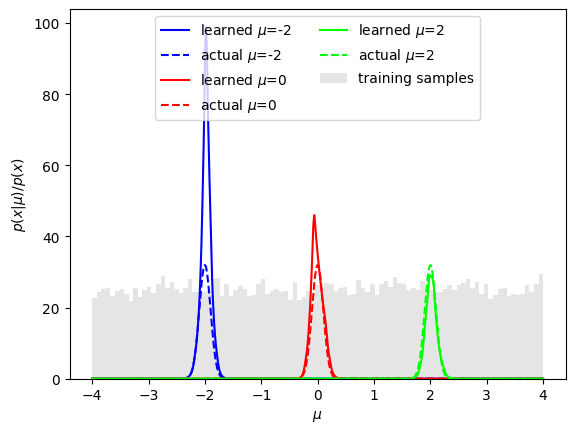

In [11]:
# get the truth
plt.figure()
colors = plt.cm.brg(np.linspace(0,1,3))

for i,k in enumerate([-2,0,2]):
    mu_plot = np.linspace(-4,4,1000)
    n_int_steps = 1000
    mu_min = -4
    mu_max = 4
    int_mu = np.linspace(mu_min, mu_max, n_int_steps)
    p_mu = np.ones_like(int_mu)/(mu_max-mu_min)    
    evidence = np.sum(stats.norm.pdf(k,int_mu, scale = 0.1) * p_mu) * (mu_max - mu_min) / n_int_steps        # p(x)
    truth = stats.norm.pdf(k, mu_plot,  scale = 0.1) / evidence
    #plt.plot(mu_plot,prediction[i]/(1-prediction[i]), label =r'learned $\mu$=%s'%k, color=colors[i])
    plt.plot(mu_plot,prediction[i], label =r'learned $\mu$=%s'%k, color=colors[i])
    plt.plot(mu_plot, truth, label=r'actual $\mu$=%s'%k, ls='--', color=colors[i])

plt.hist(mu_train, weights=np.ones_like(mu_train) * 2500/len(mu_train), bins=np.linspace(mu_plot[0],mu_plot[-1],100), color='gray', alpha=0.2, label='training samples')
plt.gca().set_xlabel(r'$\mu$')
plt.gca().set_ylabel(r'$p(x|\mu)/p(x)$')
plt.legend(ncol = 2, loc='upper center')